In [1]:
import sys
import os

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from pycqed.instrument_drivers.physical_instruments.ZurichInstruments import ZI_HDAWG8
import pycqed.measurement.kernel_functions_ZI as ZI_kf

In [4]:
sys.path.append('C:\\Users\\yvess\\zi.local\\trunk.svn\\hdl\\hirzel\\scripts')

In [5]:
from HDAWG_outcomp import *

## Define ideal step function

In [6]:
# Settings
fs = 2.4e9
time_start = -10e-9
time_start = np.around(time_start*fs)/fs
time_end = 500e-9
time = np.arange(time_start, time_end, 1/fs)
time_ns = time*1e9

# Construct impulse
impulse = np.zeros(len(time))
zero_ind = np.argmin(np.abs(time))
impulse[zero_ind] = 1.0

# Construct step
step = np.zeros(len(time))
step[time >= 0.0] = 0.5 # need amplitude < 1.0 to prevent overflow for negative exponential decay amplitudes.

In [7]:
help(ZI_kf.exponential_decay_correction_hw_friendly)

Help on function exponential_decay_correction_hw_friendly in module pycqed.measurement.kernel_functions_ZI:

exponential_decay_correction_hw_friendly(ysig, tau:float, amp:float, sampling_rate:float=1, inverse:bool=False)
    Corrects for an exponential decay using "multipath_filter2".
    
    Fitting should be done to the following function:
        y = gc*(1 + amp *exp(-t/tau))
    where gc is a gain correction factor that is ignored in the corrections.



## Define filter coefficients

In [8]:
amp = 0.1
tau = 0.1e-6

## PycQED kernel functions

In [9]:
step_kf = ZI_kf.exponential_decay_correction_hw_friendly(step, tau, amp, sampling_rate = fs)
step_kf_neg = ZI_kf.exponential_decay_correction_hw_friendly(step, tau, -amp, sampling_rate = fs)

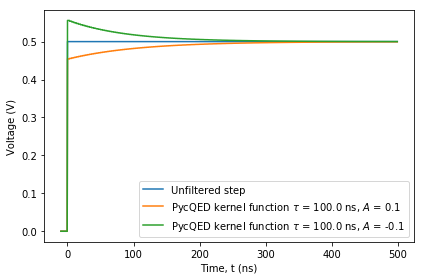

In [10]:
plt.plot(time_ns, step, label='Unfiltered step')
plt.plot(time_ns, step_kf, label=r'PycQED kernel function $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, amp))
plt.plot(time_ns, step_kf_neg, label=r'PycQED kernel function $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, -amp))
plt.legend()
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()

plt.show()

## Hardware simulation functions

In [11]:
step_sim = apply_offline_predistortion(step, fs, exp_coefs = [{'tau' : tau, 'amp' : amp}])
step_sim_neg = apply_offline_predistortion(step, fs, exp_coefs = [{'tau' : tau, 'amp' : -amp}])

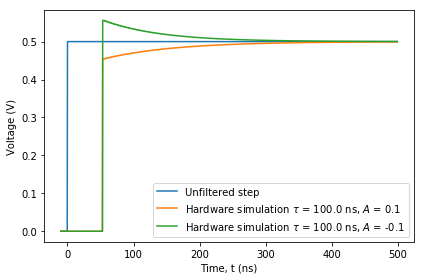

In [12]:
plt.plot(time_ns, step, label='Unfiltered step')
plt.plot(time_ns, step_sim, label=r'Hardware simulation $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, amp))
plt.plot(time_ns, step_sim_neg, label=r'Hardware simulation $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, -amp))
plt.legend()
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()

plt.show()

## Compare

In [13]:
step_kf_delay = ZI_kf.sigdelay(step_kf, 8*(EXP_FILTER_DELAY + OUTCOMP_DELAY))
step_kf_neg_delay = ZI_kf.sigdelay(step_kf_neg, 8*(EXP_FILTER_DELAY + OUTCOMP_DELAY))

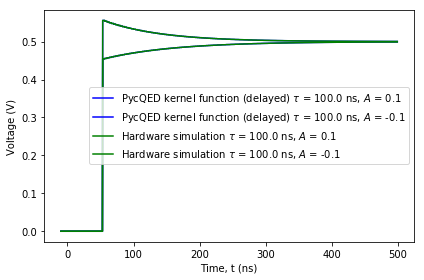

In [14]:
plt.plot(time_ns, step_kf_delay, 'b' , label=r'PycQED kernel function (delayed) $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, amp))
plt.plot(time_ns, step_kf_neg_delay, 'b', label=r'PycQED kernel function (delayed) $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, -amp))

plt.plot(time_ns, step_sim, 'g', label=r'Hardware simulation $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, amp))
plt.plot(time_ns, step_sim_neg, 'g', label=r'Hardware simulation $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, -amp))

plt.legend()
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()

plt.show()

### Zoom in

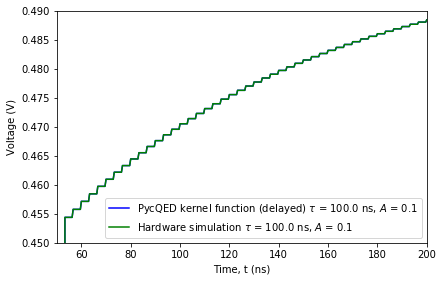

In [15]:
plt.plot(time_ns, step_kf_delay, 'b' , label=r'PycQED kernel function (delayed) $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, amp))

plt.plot(time_ns, step_sim, 'g', label=r'Hardware simulation $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, amp))

plt.legend()
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()

plt.xlim([50, 200])
plt.ylim([0.45, 0.49])

plt.show()

### Difference

In [16]:
step_diff = step_kf_delay - step_sim
step_neg_diff = step_kf_neg_delay - step_sim_neg

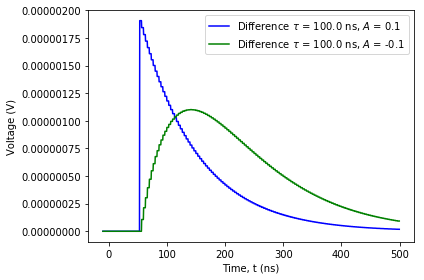

In [17]:
plt.plot(time_ns, step_diff, 'b' , label=r'Difference $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, amp))
plt.plot(time_ns, step_neg_diff, 'g', label=r'Difference $\tau$ = {} ns, $A$ = {}'.format(tau*1e9, -amp))

plt.legend()
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()

plt.show()